# ДЗ 5. Классификация изображений

Сегодня вам предстоит помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [44]:
# we will verify that GPU is enabled for this notebook
# following should print: mps is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from torch.hub import load
import pandas as pd
from torch.autograd import Variable
import torch
import numpy as np
import time
from torch.utils.data import Subset

train_on_gpu = torch.backends.mps.is_available()
DEVICE = torch.device("mps")

if not train_on_gpu:
    print('mps is not available.  Training on CPU ...')
else:
    print('mps is available!  Training on GPU ...')


mps is available!  Training on GPU ...


In [2]:
from torchvision.models import resnet50, ResNet50_Weights


In [3]:
import PIL
print(PIL.__version__)


10.1.0


In [4]:
import torch
torch.backends.mps.is_available()


True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [5]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
import torchvision
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [6]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("mps")
# можно поэксперементировать с различными batch_size
BATCH_SIZE = 32
DEVICE


device(type='mps')

In [105]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        data_transforms = {
        'train': transforms.Compose([
            transforms.RandomChoice([
                transforms.Compose([
                transforms.Resize(size=300, max_size=301),
                transforms.CenterCrop(size=300),
                transforms.RandomCrop(250)
                ]),
                transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=1)
            ]),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(my_normalization),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomChoice([
                transforms.Compose([
                transforms.Resize(size=300, max_size=301),
                transforms.CenterCrop(size=300),
                transforms.RandomCrop(250)
                ]),
                transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=1)
            ]),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(my_normalization),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
                    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                    transforms.Lambda(my_normalization),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        }
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)


In [106]:
train_files = sorted(list(TRAIN_VAL_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_files, test_size = 0.2)
train_dataset_v1 = SimpsonsDataset(train_files, mode='train')
test_dataset_v1 = SimpsonsDataset(test_files, mode = 'test')
val_dataset_v1 = SimpsonsDataset(val_files, mode='val')
train_dataset_v1 = SimpsonsDataset(train_files, mode='train')


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [94]:
def my_normalization(x):
    return np.array(x, dtype = 'float32') / 255
data_transforms = {
    'train_val': transforms.Compose([
        transforms.RandomChoice([
                transforms.Compose([
                transforms.Resize(size=300, max_size=301),
                transforms.CenterCrop(size=300),
                transforms.RandomCrop(250)
                ]),
                transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=1)
            ]),
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
        transforms.Lambda(my_normalization),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Lambda(my_normalization),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
} # все трансформеры для наших данных

test_dataset = torchvision.datasets.ImageFolder("/Users/dadaya/Desktop/progs/DLS/data/journey-springfield/testset", transform = data_transforms['test'])
train_val_folder = torchvision.datasets.ImageFolder("/Users/dadaya/Desktop/progs/DLS/data/journey-springfield/train/simpsons_dataset", transform = data_transforms['train_val'])
train_dataset, val_dataset = torch.utils.data.random_split(train_val_folder, [0.8, 0.2])


In [91]:
TEST_DIR = Path("/Users/dadaya/Desktop/progs/DLS/data/journey-springfield/testset")
TRAIN_VAL_DIR = Path("/Users/dadaya/Desktop/progs/DLS/data/journey-springfield/train/simpsons_dataset")
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_files = sorted(list(TRAIN_VAL_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
amounts = pd.Series(train_val_labels).value_counts()
amounts


homer_simpson               2246
ned_flanders                1454
moe_szyslak                 1452
lisa_simpson                1354
bart_simpson                1342
marge_simpson               1291
krusty_the_clown            1206
principal_skinner           1194
charles_montgomery_burns    1193
milhouse_van_houten         1079
chief_wiggum                 986
abraham_grampa_simpson       913
sideshow_bob                 877
apu_nahasapeemapetilon       623
kent_brockman                498
comic_book_guy               469
edna_krabappel               457
nelson_muntz                 358
lenny_leonard                310
mayor_quimby                 246
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
professor_john_frink          65
snake_jail

In [9]:
# uncomment if you have problem with pillow
def register_extension(id, extension):
    Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions


Давайте посмотрим на наших героев внутри датасета.

In [10]:
y_train_indices = train_dataset.indices

y_train = [train_val_folder.targets[i] for i in y_train_indices]

class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count

samples_weight = np.array([weight[t] for t in y_train])

samples_weight = torch.from_numpy(samples_weight)


In [11]:
sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))


In [12]:
dataloaders = {'test': torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True),
               'val': torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True),
               'train': torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, sampler = sampler)}
dataset_sizes = {'test': len(test_dataset),
                 'val': len(val_dataset),
                 'train': len(train_dataset)}
class_names = train_val_folder.classes
print(dataset_sizes, class_names)
print(len(class_names))


{'test': 991, 'val': 4186, 'train': 16747} ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
42


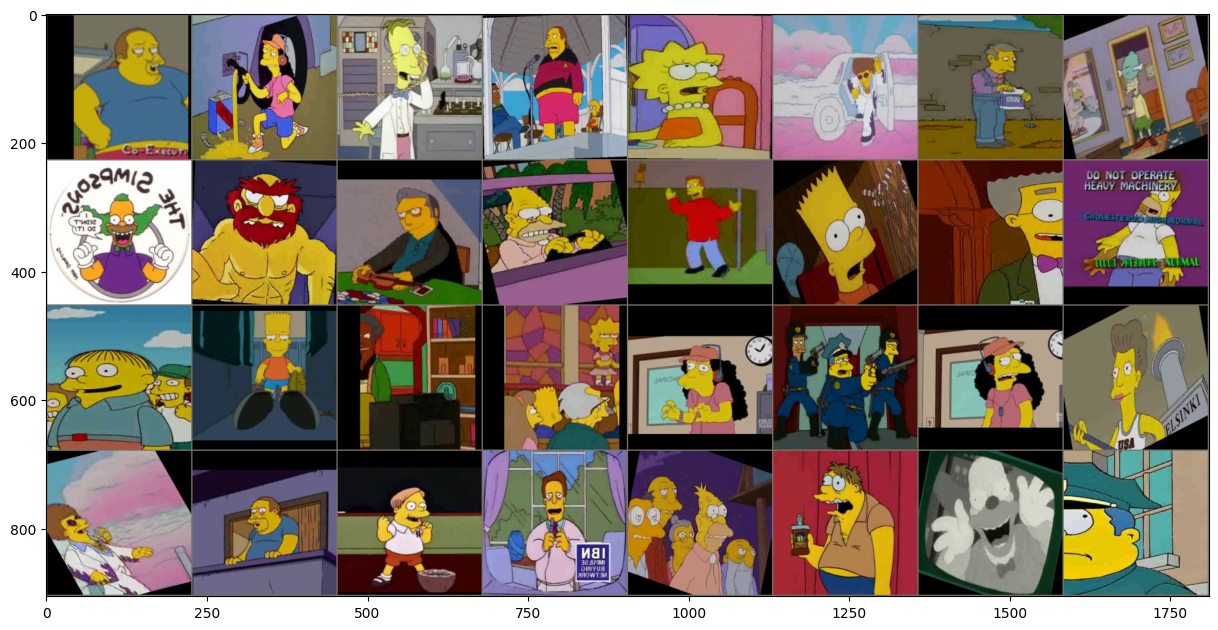

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out)


Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [14]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits


In [108]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    #Ваш код здесь
    losses = {'train': [], "val": []}
    accuracy = {'train': [], 'val': []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Ваш код здесь
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, accuracy

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs.to(DEVICE)), Variable(labels.to(DEVICE))

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']


In [16]:
class Modified_vgg16(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, dilation = 1)
        )
        self.dropout1 = nn.Dropout(p=0.3)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, dilation = 1)
        )
        self.dropout2 = nn.Dropout(p=0.3)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, dilation = 1)
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, dilation = 1),
            nn.BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.dropout3 = nn.Dropout(p=0.3)
        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.conv12 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.dropout4 = nn.Dropout(p=0.3)
        self.conv13 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, dilation = 1),
            nn.BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.fc1 = nn.AdaptiveAvgPool2d(output_size = (7, 7))
        self.fc2 = nn.Linear(25088, n_classes, bias = True)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.dropout3(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.dropout4(x)
        x = self.conv13(x)
        x = self.fc1(x)

        x = x.view(x.size(0), -1)
        out = self.fc2(x)
        return out


Запустим обучение сети.

In [17]:
modified_vgg16 = Modified_vgg16(42)
modified_vgg16 = modified_vgg16.to(DEVICE)
optimizer = optim.Adam(modified_vgg16.parameters() , lr = 1e-4)
loss_fn = nn.CrossEntropyLoss()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
modified_vgg16, losses_modified_vgg16, accuracy_modified_vgg16 = train_model(modified_vgg16, loss_fn, optimizer, exp_lr_scheduler, num_epochs = 25)


Epoch::   0%|          | 0/25 [00:00<?, ?it/s]/Users/dadaya/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
val Loss: 0.0157 Acc: 0.8636: 100%|██████████| 25/25 [8:28:58<00:00, 1221.53s/it]    

Training complete in 508m 58s
Best val Acc: 0.864787


In [18]:
torch.save(modified_vgg16.state_dict(), 'Modified_vgg16.pth')


In [19]:
modified_vgg16.load_state_dict(torch.load('Modified_vgg16.pth'))


<All keys matched successfully>

In [20]:
print("Accuracy: {0:.4f}".format(evaluate(modified_vgg16)))


Accuracy: 0.8650


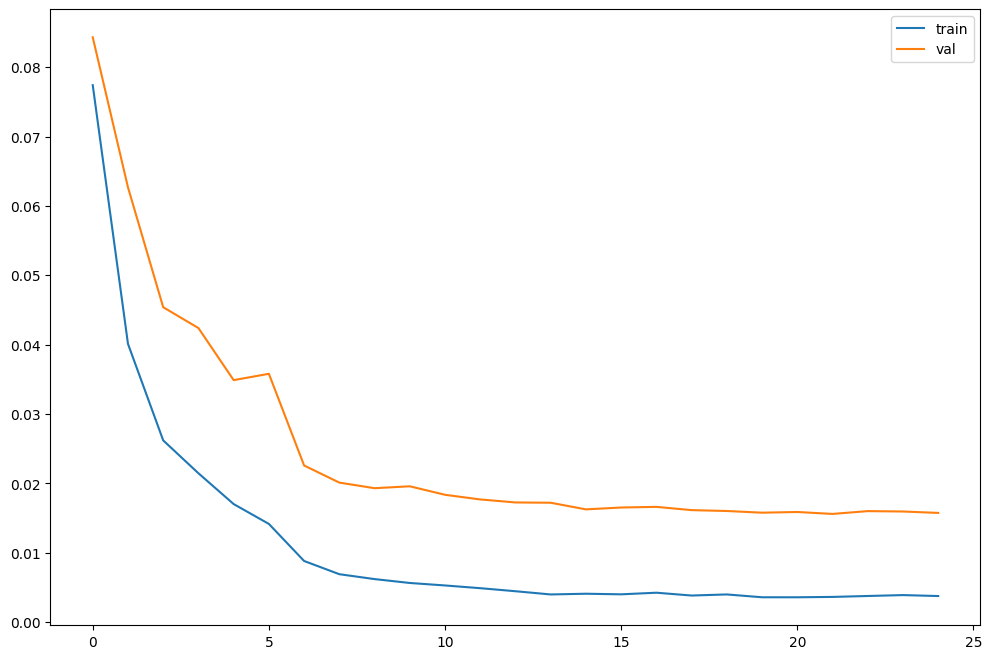

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(losses_modified_vgg16['train'], label="train")
plt.plot(losses_modified_vgg16['val'], label="val")
plt.legend()
plt.show()


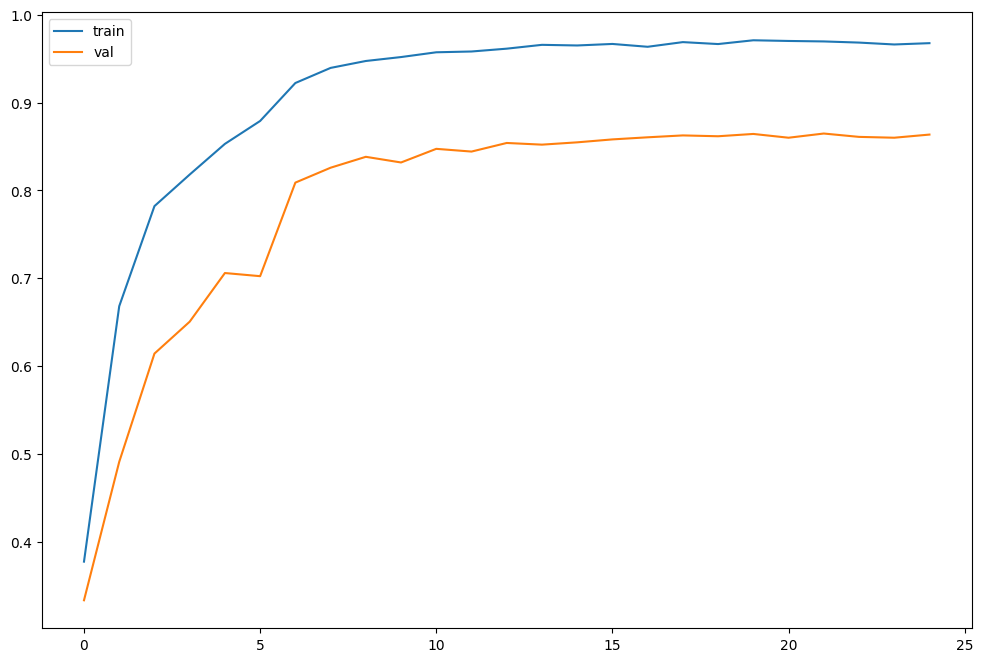

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(accuracy_modified_vgg16['train'], label="train")
plt.plot(accuracy_modified_vgg16['val'], label="val")
plt.legend()
plt.show()


# Да, из пушки по воробьям, но все же)

In [23]:
res_net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)


In [25]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
res_net.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
res_net = res_net.to(DEVICE)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer_resnet = optim.Adam(res_net.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

res_net


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
res_net, losses_resnet, accuracy_resnet = train_model(res_net, loss_fn, optimizer_resnet, exp_lr_scheduler, num_epochs = 25)


val Loss: 0.0028 Acc: 0.9799: 100%|██████████| 25/25 [5:09:23<00:00, 742.52s/it]    

Training complete in 309m 23s
Best val Acc: 0.981605


In [27]:
torch.save(res_net.state_dict(), 'ResNet.pth')


In [28]:
res_net.load_state_dict(torch.load('ResNet.pth'))


<All keys matched successfully>

In [29]:
print("Accuracy: {0:.4f}".format(evaluate(res_net)))


Accuracy: 0.9787


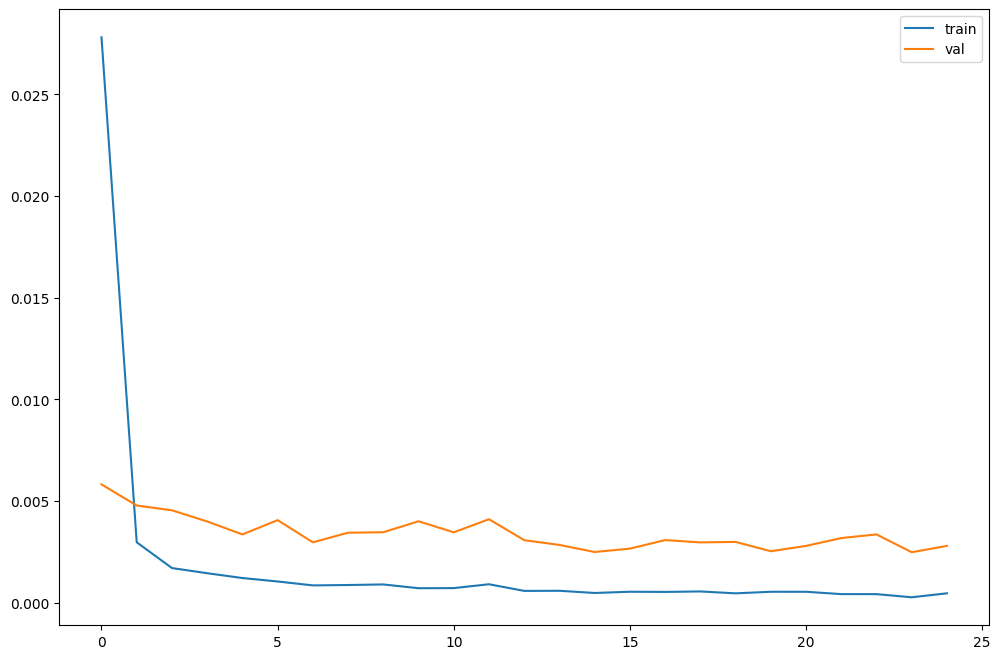

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(losses_resnet['train'], label="train")
plt.plot(losses_resnet['val'], label="val")
plt.legend()
plt.show()


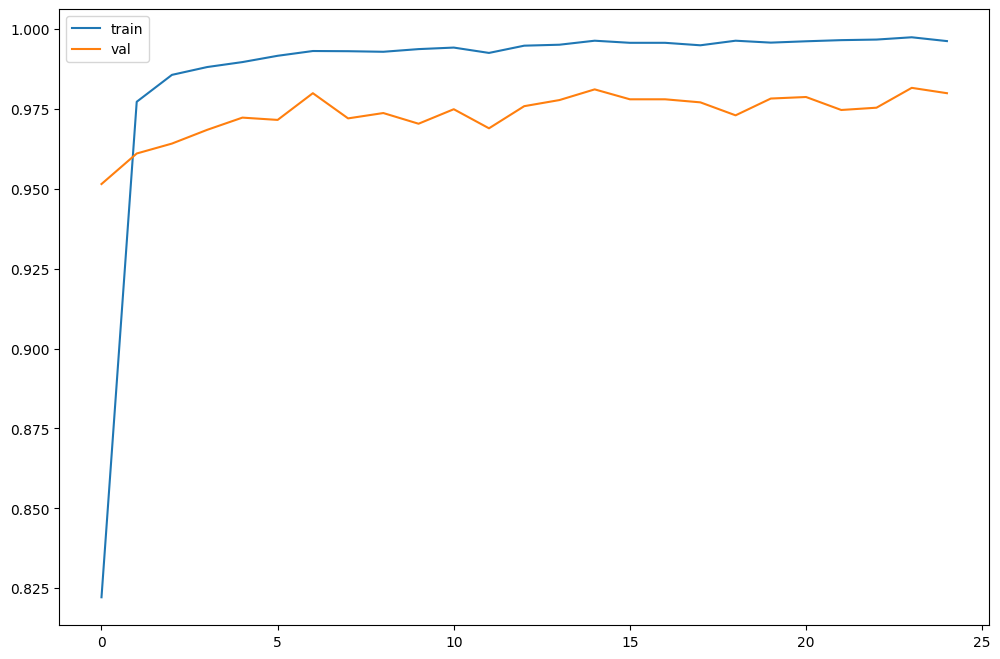

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(accuracy_resnet['train'], label="train")
plt.plot(accuracy_resnet['val'], label="val")
plt.legend()
plt.show()


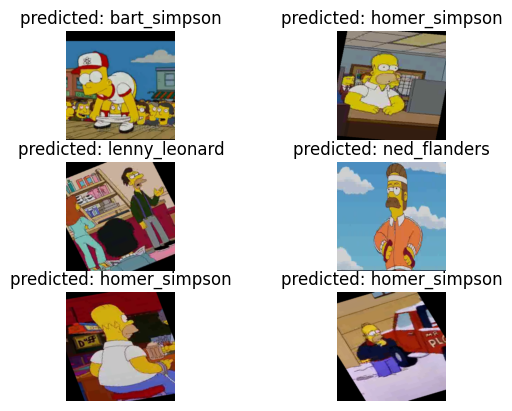

In [78]:
visualize_model(res_net)


# Для сабмита будем использовать ResNet

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-sicudaons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [79]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


In [80]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(res_net, ex_img.unsqueeze(0))


In [81]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(res_net, imgs)


In [82]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
label_encoder


LabelEncoder()

In [83]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]


Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [84]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

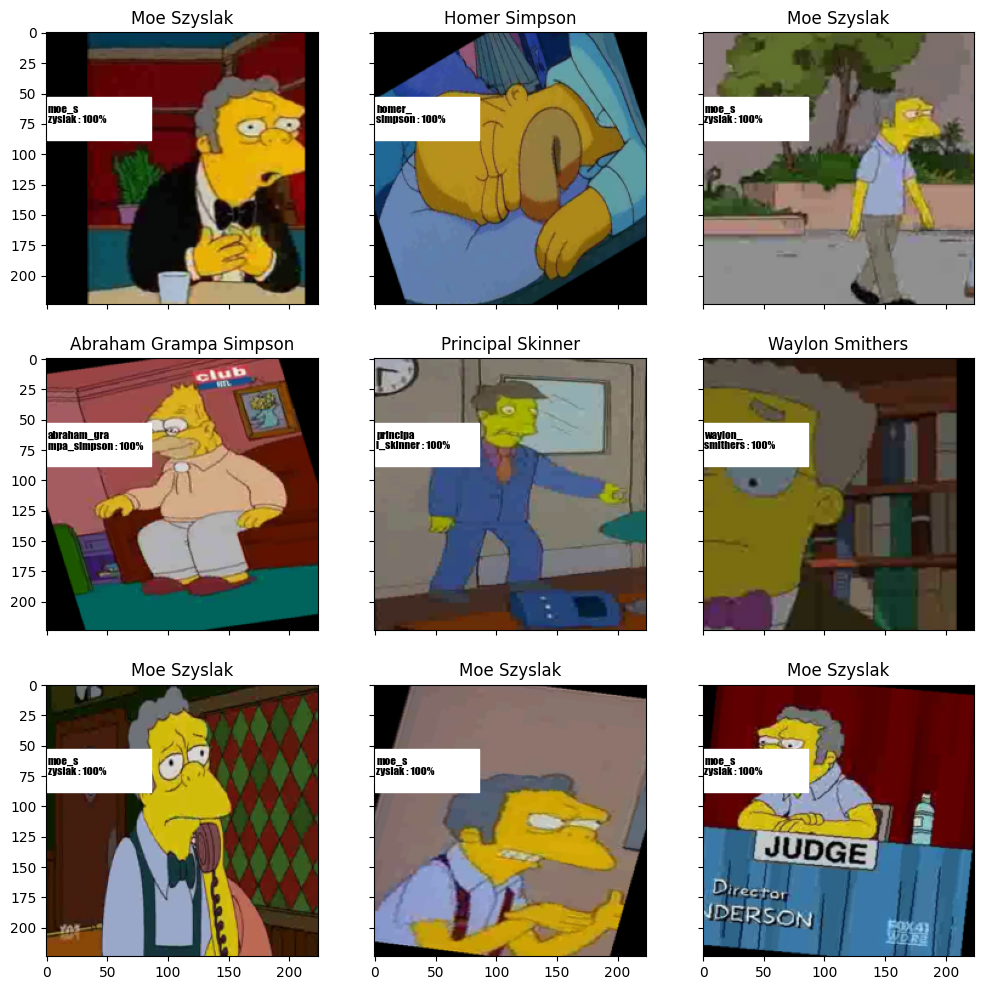

In [97]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset_v1.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(res_net, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')


### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [109]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(res_net, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset_v1.files]


In [115]:
import pandas as pd
# my_submit = pd.read_csv("/Users/dadaya/Desktop/progs/DLS/data/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [117]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)
